<a href="https://colab.research.google.com/github/karima33/python_projects/blob/main/To_Do_CP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import string
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data 

In [3]:
data = pd.read_csv('/content/Consumer_Complaints.csv', engine='python', encoding='utf-8', error_bad_lines=False, sep=',')

Skipping line 209212: unexpected end of data


In [4]:
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer Complaint,Company Public Response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date Sent to Company,Company Response to Consumer,Timely response?,Consumer disputed?,Complaint ID,Unnamed: 18
0,03-12-2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217,NaN
1,10-01-2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10-05-2016,Closed with explanation,Yes,No,2141773,NaN
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100,NaN
3,06-08-2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06-10-2014,Closed with explanation,Yes,Yes,885638,NaN
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760,NaN


In [5]:
import pandas as pd 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)


In [6]:
data = data[["Product","Consumer Complaint"]]

In [7]:
data

,Product,Consumer Complaint
0,Mortgage,NaN
1,Credit reporting,I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements
2,Consumer Loan,"I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had been paid in full ( dated XXXX, XXXX ) but no refund check was included. XXXX stated that they hold any over payment for 10 business days after the loan was satisfied and that my check would be mailed out on Wed. the XX/XX/XXXX.. I questioned her about the delay in posting the dealer payment and she first stated that sometimes it takes 3 or 4 business days to post, then she said they did not receive the check till XXXX XXXX I again told her that I did not believe this and asked where is my money. She then stated that they hold the over payment for 10 business days. I asked her why, and she simply said that is their policy. I asked her if I would receive interest on my money and she stated no. I believe that Citizens bank is deliberately delaying the posting of payment and the return of consumer 's money to make additional interest for the bank. If this is not illegal it should be, it does hurt the consumer and is not ethical. My amount of money lost is minimal but if they are doing this on thousands of car loans a month, then the additional interest earned for them could be staggering. I still have another car loan from Citizens Bank and I am afraid when I trade that car in another year I will run into the same problem again."
3,Credit card,NaN
4,Debt collection,NaN
...,...,...
209205,Credit reporting,NaN
209206,Mortgage,"I have started going through a hardship since me divorce was finalized in 2014. My ex husband stopped paying half of the bills like we were both accustomed to doing. I lost my XXXX after Making Healthcare Affordable Act was passed because those employers needed to make sure everyone had coverage or they had to pay a fine. After the last unemployment term for 2 weeks, I found a job working at a XXXX XXXX making {$XXXX}. This salary barely covered filling my car 's gas tank weekly. I was able to pay certain bills but not all of them. After working there for 4 months, I found another job making more money. I started getting caught up on the bills and 3 weeks later, the job ended. I found myself unemployed for two more weeks. I did finally found a job making more money and now i am trying to get back on track. I had did a Loss Mitigation package three times and every time I leave voicemail messages for the XXXX contact people I have, no one never returns my calls. I need an answer because I want a resolution that will be fair to me."
209207,Credit card,NaN
209208,Consumer Loan,NaN


In [8]:
data.head()

,Product,Consumer Complaint
0,Mortgage,NaN
1,Credit reporting,I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements
2,Consumer Loan,"I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had been paid in full ( dated XXXX, XXXX ) but no refund check was included. XXXX stated that they hold any over payment for 10 business days after the loan was satisfied and that my check would be mailed out on Wed. the XX/XX/XXXX.. I questioned her about the delay in posting the dealer payment and she first stated that sometimes it takes 3 or 4 business days to post, then she said they did not receive the check till XXXX XXXX I again told her that I did not believe this and asked where is my money. She then stated that they hold the over payment for 10 business days. I asked her why, and she simply said that is their policy. I asked her if I would receive interest on my money and she stated no. I believe that Citizens bank is deliberately delaying the posting of payment and the return of consumer 's money to make additional interest for the bank. If this is not illegal it should be, it does hurt the consumer and is not ethical. My amount of money lost is minimal but if they are doing this on thousands of car loans a month, then the additional interest earned for them could be staggering. I still have another car loan from Citizens Bank and I am afraid when I trade that car in another year I will run into the same problem again."
3,Credit card,NaN
4,Debt collection,NaN


In [9]:
data.Product.value_counts()

Mortgage                                                                        59167
Debt collection                                                                 39878
Credit reporting                                                                35881
Credit card                                                                     22993
Bank account or service                                                         21649
Student loan                                                                    8822 
Consumer Loan                                                                   8233 
Credit reporting, credit repair services, or other personal consumer reports    5003 
Credit card or prepaid card                                                     1397 
Checking or savings account                                                     1391 
Payday loan                                                                     1359 
Money transfers                                       

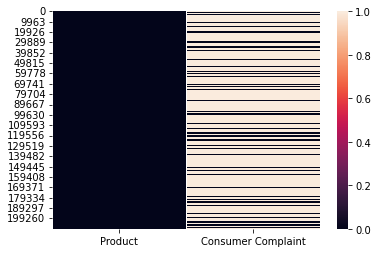

In [10]:
sns.heatmap(data.isnull())

# Preprocessing & Vizz

In [11]:
# We will group some product types 
data.loc[data['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
data.loc[data['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
data.loc[data['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
data.loc[data['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'


In [12]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [13]:
data['Product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints', 
                                                                title='Number complaints in each product')
data = data[data.Product != None]


In [14]:
data = data.reset_index(drop=True)

In [17]:
def complaint_product(indx,data):
  complaint = data['Consumer Complaint'][indx]
  product = data['Product'][indx]
  print(complaint)
  print('------------------------------')
  print("Product : ",product)

In [18]:
complaint_product(238, data)

nan
------------------------------
Product :  Mortgage


In [19]:
def print_plot(index):
    example = data[data.index == index][['Consumer Complaint', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [20]:
print_plot(100)

nan
Product: Bank account or service


In [21]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers, remove stop words and Xs.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [26]:
# Code Here
data['Consumer Complaint'].astype(str).apply(clean_text)

0         nan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [27]:
# After cleaning
complaint_product(238, data)

nan
------------------------------
Product :  Mortgage


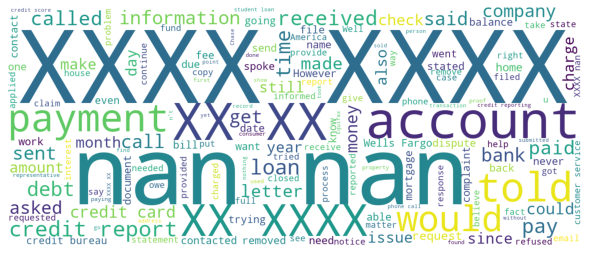

In [29]:
text = " ".join(complaint for complaint in data["Consumer Complaint"].astype(str))
# Generate a word cloud image

wordcloud = WordCloud(width = 1200, height = 500, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [31]:
number_words = [len(complaints.split(' ')) for complaints in data["Consumer Complaint"].astype(str)]

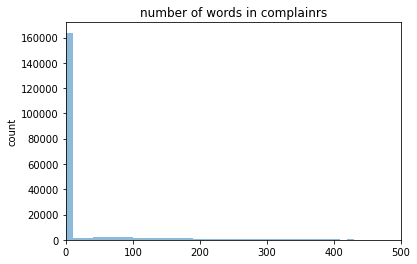

In [32]:
# fixed bin size
bins = np.arange(-0, 3000, 10) # fixed bin size

plt.xlim([0, 500])

plt.hist(number_words, bins=bins, alpha=0.5)
plt.title('number of words in complainrs')
plt.ylabel('count')

plt.show()

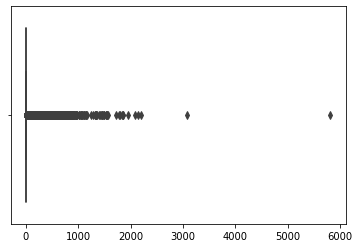

In [33]:
sns.boxplot(number_words)

# Multi-Class Text Classification LSTM 

In [35]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['Consumer Complaint'].astype(str).values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 41347 unique tokens.


In [38]:
X = tokenizer.texts_to_sequences(data['Consumer Complaint'].astype(str).values)#list of integers
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #padding
print('Shape of data tensor:', X.shape)

Shape of data tensor: (209210, 250)


In [39]:
labels = list(pd.get_dummies(data['Product']).columns)
Y = pd.get_dummies(data['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (209210, 14)


In [58]:
# Code Here
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 1234)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(167368, 250) (167368, 14)
(41842, 250) (41842, 14)


In [59]:
# Code Here
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(14, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_5 (Dense)             (None, 14)                1414      
                                                                 
Total params: 5,081,814
Trainable params: 5,081,814
Non-trainable params: 0
_________________________________________________________________
None


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param   
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909    
_________________________________________________________________

Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0


In [61]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
2354/2354 [==============================] - 1877s 797ms/step - loss: 1.7726 - accuracy: 0.3574 - val_loss: 1.7636 - val_accuracy: 0.3561
Epoch 2/5
2354/2354 [==============================] - 1842s 782ms/step - loss: 1.6867 - accuracy: 0.3854 - val_loss: 1.6447 - val_accuracy: 0.3960
Epoch 3/5
2354/2354 [==============================] - 1837s 780ms/step - loss: 1.6263 - accuracy: 0.4058 - val_loss: 1.6107 - val_accuracy: 0.4100
Epoch 4/5
2354/2354 [==============================] - 1815s 771ms/step - loss: 1.5895 - accuracy: 0.4186 - val_loss: 1.6004 - val_accuracy: 0.4148
Epoch 5/5
2354/2354 [==============================] - 1838s 781ms/step - loss: 1.5640 - accuracy: 0.4262 - val_loss: 1.5950 - val_accuracy: 0.4158


In [62]:
# evaluate model on test set
score = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

1308/1308 [==============================] - 146s 112ms/step - loss: 1.5890 - accuracy: 0.4198
Test set
  Loss: 1.59
  Accuracy: 0.42


In [83]:
Y_pred = model.predict(X_test)

1308/1308 [==============================] - 115s 88ms/step


In [91]:
predicted_classes = np.argmax(Y_pred, axis=1)

In [92]:
# Code Here
expected_classes = Y_test

In [93]:
predicted_classes

array([8, 3, 8, ..., 3, 8, 8])